In [ ]:
!pip install wfdb
!pip install import-ipynb
!pip install imbalanced-learn
from google.colab import drive
ROOT = '/content/drive'
drive.mount('/content/drive')

In [2]:
%cd "drive/My Drive/Colab Notebooks/Python/MLP_arrhythmia_database/Resultados_MLP_Arritmia"

/content/drive/My Drive/Colab Notebooks/Python/MLP_arrhythmia_database/Resultados_MLP_Arritmia


In [3]:
import wfdb
from wfdb import processing
import math
import pywt
import pandas as pd
import numpy as np
from numpy import *
from numpy import load
import scipy.io as sio
import numpy.matlib 
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from scipy import signal
from os import listdir
%matplotlib inline

from sklearn.metrics import roc_auc_score, accuracy_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from scipy.interpolate import interp1d
import json

import import_ipynb
from SeparacaoAAMI import *

import random   
random.seed(30) 

ind_plt_recall = 0

importing Jupyter notebook from SeparacaoAAMI.ipynb


In [4]:
fs = 360
pasta = 'mit-bih-arrhythmia-database-1.0.0/'
DS1 = ['101', '106', '108', '109', '112', '114', '115', '116', '118', '119', '122', '124', '201', '203', '205', '207', '208', '209', '215', '220', '223', '230']
DS2 = ['100', '103', '105', '111', '113', '117', '121', '123', '200', '202', '210', '212', '213', '214', '219', '221', '222', '228', '231', '232', '233', '234']
N = ['N', 'L', 'R', 'e', 'j']
S = ['A', 'a', 'J', 'S']
V = ['V', 'E']
F = ['F']
Q = ['/', 'f', 'Q']
nonbeat = ['[', ']', '!', 'x', '|', '~', '+', '"']
with open('simbolos_versaofinal.json', 'r') as json_file:
    simbolos = json.load(json_file)

In [5]:
periodo = 320
X_train, Y_train_int, Sym_train = datasetAAMIChazal5(pasta, DS1, periodo, fs, simbolos)
X_test, Y_test_int, Sym_test =    datasetAAMIChazal5(pasta, DS2, periodo, fs, simbolos)

In [6]:
print(X_train.shape)
print(X_test.shape)

(12224, 320)
(12037, 320)


In [7]:
from sklearn.utils import class_weight

Y_train_flat = Y_train_int.flatten()
pesos = class_weight.compute_class_weight('balanced', np.unique(Y_train_flat), Y_train_flat)
print(pesos)
pesos = pesos*10
pesos = list(map(math.ceil,pesos))
pesos = {i: pesos[i] for i in range(np.size(pesos))}

pesos

[2.86477619e-01 3.23814570e+00 9.63278172e-01 6.17373737e+00
 2.44480000e+03]


{0: 3, 1: 33, 2: 10, 3: 62, 4: 24448}

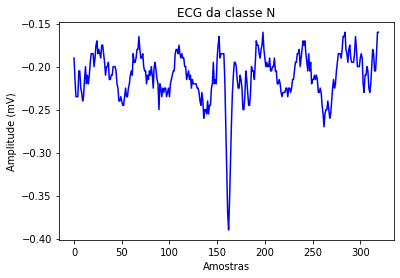

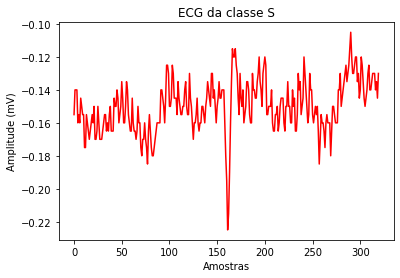

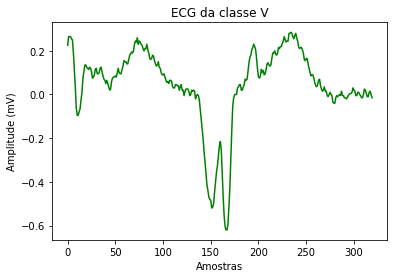

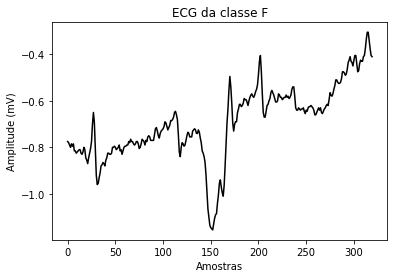

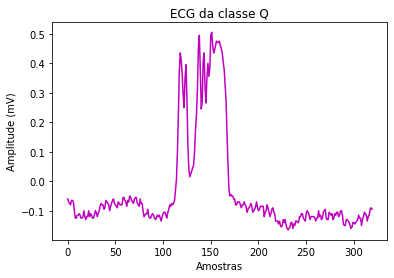

In [8]:
id1 = np.where(Y_train_int == 0)[0][0]
id2 = np.where(Y_train_int == 1)[0][0]
id3 = np.where(Y_train_int == 2)[0][0]
id4 = np.where(Y_train_int == 3)[0][0]
id5 = np.where(Y_train_int == 4)[0][0]
plotECG(False, X_train, id1, id2, id3, id4, id5)

In [9]:
numclass = 5

#one hot encoding
Y_train = np.eye(numclass)[Y_train_int.astype('int32')]
Y_test = np.eye(numclass)[Y_test_int.astype('int32')]
Y_train = Y_train.T.reshape(numclass, X_train.shape[0])
Y_test = Y_test.T.reshape(numclass, X_test.shape[0])

Y_train = Y_train.T
Y_test = Y_test.T

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12224, 320)
(12037, 320)
(12224, 5)
(12037, 5)


Construindo a MLP

In [10]:
split = X_test.shape[0]/(X_test.shape[0] + X_train.shape[0])
print(split)
all_X = np.concatenate((X_train, X_test), axis = 0)
all_label = np.concatenate((Y_train, Y_test), axis = 0)
print(all_X.shape, all_label.shape)

0.49614607806768063
(24261, 320) (24261, 5)


In [11]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(12224, 320)
(12037, 320)
(12224, 5)
(12037, 5)


In [12]:
model = tf.keras.Sequential()
model.add(layers.Dense(64, activation = 'relu', input_shape = (all_X.shape[1],)))
model.add(layers.Dropout(0.25))
model.add(layers.Dense(64, activation = 'relu'))
model.add(layers.Dropout(0.15))

model.add(layers.Dense(numclass, activation = 'softmax'))

adam = tf.keras.optimizers.Adam(learning_rate= 0.001, beta_1=0.9, beta_2=0.99, epsilon=1e-07)
model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy', tf.keras.metrics.Recall()])

history = model.fit(all_X, all_label, batch_size=2048, shuffle=True, epochs=1000, validation_split=split, verbose = False, class_weight = pesos) #validationsplit pega os ultimos dados de all_X antes do shuffle

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                20544     
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 325       
Total params: 25,029
Trainable params: 25,029
Non-trainable params: 0
_________________________________________________________________


In [14]:
Y_train_preds = model.predict(X_train, verbose = 0)
Y_test_preds = model.predict(X_test, verbose = 0)

In [17]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

print('-------------------------Treino------------------------')

Y_hat_train = np.argmax(Y_train_preds, axis=1)
Y_real_train = np.argmax(Y_train, axis=1)
print(confusion_matrix(Y_real_train, Y_hat_train))
print(classification_report(Y_real_train, Y_hat_train, digits = 4, zero_division=0))

print('-------------------------Teste------------------------')

Y_hat_test = np.argmax(Y_test_preds, axis=1)
Y_real_test = np.argmax(Y_test, axis=1)
M = confusion_matrix(Y_real_test, Y_hat_test)
print(confusion_matrix(Y_real_test, Y_hat_test))
print(classification_report(Y_real_test, Y_hat_test, digits = 4, zero_division=0))


-------------------------Treino------------------------
[[8455   38   30   11    0]
 [   4  751    0    0    0]
 [   8    2 2519    9    0]
 [   0    0    0  396    0]
 [   0    0    0    0    1]]
              precision    recall  f1-score   support

           0     0.9986    0.9907    0.9946      8534
           1     0.9494    0.9947    0.9715       755
           2     0.9882    0.9925    0.9904      2538
           3     0.9519    1.0000    0.9754       396
           4     1.0000    1.0000    1.0000         1

    accuracy                         0.9917     12224
   macro avg     0.9776    0.9956    0.9864     12224
weighted avg     0.9919    0.9917    0.9917     12224

-------------------------Teste------------------------
[[4576  652 2488  587    0]
 [ 186   71 1037   24    1]
 [ 267   66 1668   33    0]
 [  16    1  270   89    0]
 [   1    0    3    1    0]]
              precision    recall  f1-score   support

           0     0.9069    0.5511    0.6856      8303
         

In [16]:
TN = M[0,0]
TPv = M[2,2]
TPs = M[1,1]
TPf = M[3,3]
TPq = M[4,4]
Spec = 100*TN/np.sum(M[0,:])
Sensi_F = 100*TPf/np.sum(M[3,:])
Sensi_Q = 100*TPq/np.sum(M[4,:])
print('------Normal------')
print('\n', 'Especificidade:', Spec, '\n')

TNs = M[0,0] + np.sum(M[0, 2:]) + np.sum(M[2:, 0]) + np.sum(M[2:, 2:])
FNs = np.sum(M[1, 0]) + np.sum(M[1, 2:])
TPs = M[1,1]
FPs = M[0, 1] + np.sum(M[2:4, 1])
Sensi_SVEB = 100*TPs/(TPs + FNs)
Spec_SVEB = 100*TNs/(TNs + FPs)
Preci_SVEB = 100*TPs/(TPs + FPs)
FPR_SVEB = 100*FPs/(TNs + FPs)
Acc_SVEB = 100*(TPs + TNs)/(TPs + TNs + FPs + FNs)
HM_SVEB = 2*Sensi_SVEB*Spec_SVEB/(Sensi_SVEB + Spec_SVEB)
print('------SVEB------')
print('\n', 'Sensibilidade:', Sensi_SVEB, '\n', 'Especificidade:', Spec_SVEB, '\n','Precisão:', Preci_SVEB, '\n', 'Taxa de Falsos Positivos:', FPR_SVEB, '\n', 'Acurácia:', Acc_SVEB, '\n', 'HM:', HM_SVEB, '\n')

TNv = np.sum(M[0:2, 0:2]) + np.sum(M[3:, 0:2]) + np.sum(M[0:2, 3:]) + np.sum(M[3:, 3:])
FNv = np.sum(M[2, 0:2]) + np.sum(M[2, 3:])
TPv = M[2,2]
FPv = M[0, 2] + M[1, 2]
Sensi_VEB = 100*TPv/(TPv + FNv)
Spec_VEB = 100*TNv/(TNv + FPv)
Preci_VEB = 100*TPv/(TPv + FPv)
FPR_VEB = 100*FPv/(TNv + FPv)
Acc_VEB = 100*(TPv + TNv)/(TPv + TNv + FPv + FNv)
HM_VEB = 2*Sensi_VEB*Spec_VEB/(Sensi_VEB + Spec_VEB)
print('------VEB------')
print('\n', 'Sensibilidade:', Sensi_VEB, '\n', 'Especificidade:', Spec_VEB, '\n', 'Precisão:', Preci_VEB, '\n', 'Taxa de Falsos Positivos:', FPR_VEB, '\n', 'Acurácia:', Acc_VEB, '\n', 'HM:', HM_VEB, '\n')

print('------F------')
print('\n', 'Sensibilidade:', Sensi_F, '\n')


print('------Q------')
print('\n', 'Sensibilidade:', Sensi_Q, '\n')

------Normal------

 Especificidade: 55.112609900036134 

------SVEB------

 Sensibilidade: 5.382865807429871 
 Especificidade: 93.29165889158425 
 Precisão: 8.987341772151899 
 Taxa de Falsos Positivos: 6.708341108415749 
 Acurácia: 83.65871894990447 
 HM: 10.17844235475577 

------VEB------

 Sensibilidade: 82.00589970501476 
 Especificidade: 63.77183967112025 
 Precisão: 32.12016175621028 
 Taxa de Falsos Positivos: 36.22816032887975 
 Acurácia: 66.92451547092826 
 HM: 71.74850029167494 

------F------

 Sensibilidade: 23.670212765957448 

------Q------

 Sensibilidade: 0.0 

